---------------------------
skew score of numerical features:
---------------------------
                           skew_score
TeamID_a                     0.403882
Team_lost_count_diff         0.064630
Team_lost_socre_sum_diff     0.027869
Ast_diff                     0.018633
Stl_diff                     0.016671
OR_diff                      0.016102
DR_diff                      0.014004
Score_diff                   0.010617
FTM_count_diff               0.007246
FGM3_count_diff             -0.007055
FGM3_rate_diff              -0.011409
TO_diff                     -0.013266
win                         -0.016470
PF_diff                     -0.018087
Team_win_count_diff         -0.018172
Blk_diff                    -0.018262
Team_win_score_sum_diff     -0.029815
win_rate_diff               -0.048955
FGM2_rate_diff              -0.049959
Season                      -0.091823
Score_mean_diff             -0.126518
DayNum                      -0.303413
Seed_total_count_avg_diff   -0.32981

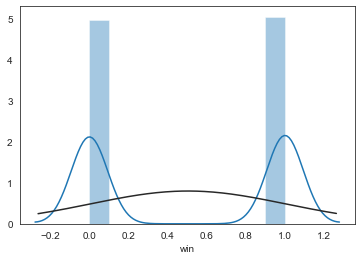

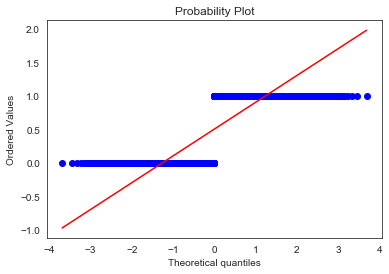

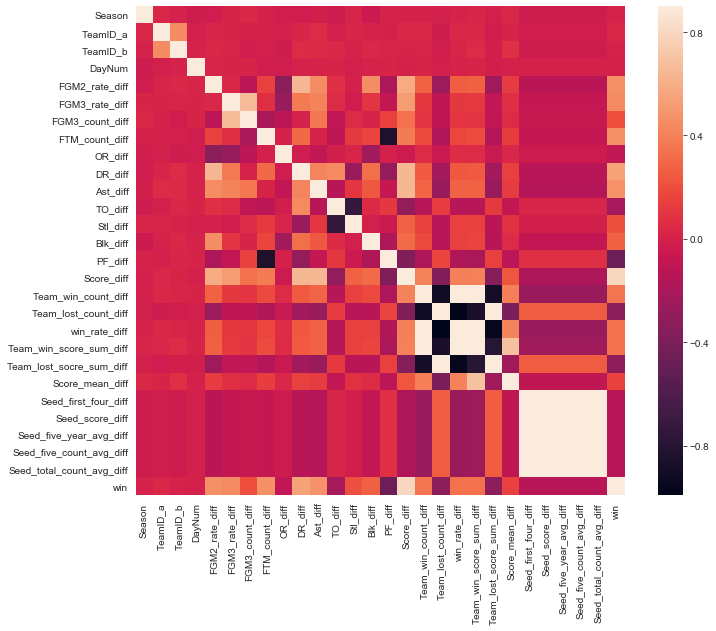

Does the dummy variables created in a right way? True
After creating dummy variables, the total number of features are:  (6072, 30)


In [55]:
# data manipulation
import pandas as pd
import numpy as np
import warnings
from scipy.stats import norm, skew
from scipy import stats
from sklearn.preprocessing import StandardScaler

warnings.simplefilter('ignore')

# data visulization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

# Read in datamart
df_datamart = pd.read_csv(f'./input/datamart/datamart_v2.csv', index_col=0)

'''By checking the info of the df_datamart, the following vaiables are 'object' type and needs to be converted
    to numeric when training data:
        1. ID (Needs to be dropped when training)
        2. ID_DayNum (Needs to be dropped)
        3. Seed_a
        4. Seed_b
        5. Team_a_Loc
        6. Team_b_Loc
        7. Label (Label needs to be dropped)'''


# --------------------------------------1. Data Preparing--------------------------------------------------------
# Check missing
def check_missing(df):
    col_names = df.columns.to_series()
    col_dtypes = df.dtypes
    col_na_count = df.isnull().sum()
    col_describe = df.describe().T
    col_unique = df.nunique()

    base_info = pd.concat([col_names, col_dtypes, col_na_count, col_unique],
                          axis=1, keys=['col_names', 'col_dtypes',
                                        'col_na_count', 'col_unique'], sort=False)
    base_info = pd.concat([base_info, col_describe], axis=1, sort=False)

    return base_info


'''1. Review一下filter2是否filter正确'''


def filter(df):
    # 1. Filter out records without DayNum (i.e., DayNum == 999), which means there's no contest happened
    filter1 = df[df['DayNum'] != 999]
    # 2. Filter out the teams without seed, which means those teams never in tourney and useless
    filter2 = filter1[~ ((filter1['Seed_a'].isnull()) | (filter1['Seed_b'].isnull()))]
    return filter2


# Check for distribution (for y or others)
def check_distribution(df, check_list):
    num_feature_list = df.dtypes[df.dtypes != 'object'].index
    skew_score = df[num_feature_list].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print('---------------------------')
    print('skew score of numerical features:')
    print('---------------------------')
    skewness = pd.DataFrame({'skew_score': skew_score})
    print(skewness)

    for feature in check_list:
        try:
            sns.distplot(df[feature], fit=norm)
            fig = plt.figure()
            res = stats.probplot(df[feature], plot=plt)

            print('---------------------------')
            print('Skewness of " %s " is: %f' % (feature, df[feature].skew()))
            print('Kurtosis of " %s " is: %f' % (feature, df[feature].kurt()))
            print('---------------------------')
        except ValueError:
            print(str(feature) + 'ValueError')


# Check for numeric variable correlations
def check_correlations(df, check_type='num_feature', target='win'):
    if check_type == 'num_feature':
        check_list = df.dtypes[df.dtypes != 'object'].index
        corrmat = df[check_list].corr()
        plt.subplots(figsize=(12, 9))
        sns.heatmap(corrmat, vmax=0.9, square=True)
        plt.show()

    elif check_type == 'target':
        k = 10  # number of features for heatmap
        corrmat = df.corr()
        cols = corrmat.nlargest(k, target)[target].index
        cm = np.corrcoef(df[cols].values.T)
        sns.set(font_scale=1.25)
        sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                    yticklabels=cols.values, xticklabels=cols.values)
        plt.show()
    return corrmat


if __name__ == '__main__':
    # Check the missing condition of original datamart
    datamart_check = check_missing(df_datamart)

    # Filter out useless records and check missing condition
    filter = filter(df_datamart)
    filter_check = check_missing(filter)

    # Among the filtered records, check the proportion of regular and tourney counts
    count_prep = filter.groupby('Label').count()

    # Check if there's any duplicates based on ID_DayNum
    check_dup = filter[filter.duplicated('ID_DayNum', keep=False)]  # No duplicates found! Good!

    # Check distribution of target: win,Score_diff
    target_list = ['win']
    check_dist = check_distribution(filter, target_list)

    # Check correlations among variable
    check_corr = check_correlations(filter)
    # a.to_excel(r'E:\DS_DA_prep\Kaggle\NCCA\2020-NCAAM\output\corr_check2.xlsx')

# ---------------------------------------2. Feature Engineering--------------------------------------
'''1. Process:
        a. Drop unnecessary variables: ID, ID_DayNum, TeamID_a, TeamID_b, DayNum(?),Seed_a,Seed_b;
        b. Extract seed location (到底有没有意义？因为季前赛的seed是用季后赛填的）
        c. Variables need to be one-hot: Team_a_Loc, Team_b_Loc,Label
        d. Add one variable: Seed_Score_diff (Seed_Score_a - Seed_Score_b)
'''
'''Questions/Concerns:
        a. Whether DayNum be used as a feature? If so, categorical or numeric?
        b. Team_a_Loc and Team_b_Loc 基本就是反的，怎么处理？ - Done
        c. Season 处理成Categorical 还是Numeric? - Numeric
        d. Filter 出来的data只有03年以后的？？？？- Done
'''
# Reset the index of the final dataframe before starting feature engineering
df_final = filter.reset_index().drop('index', axis=1)

# Drop unecessary variables
drop_list = ['ID', 'ID_DayNum', 'TeamID_a', 'TeamID_b', 'DayNum', 'Seed_a', 'Seed_b'
             # 'Team_b_Loc'
             ]  # Whether DayNum will be used as a feature needs to be discussed

ID = df_final[drop_list]  # Keep ID variables to refer back later
df_final_drop = df_final.drop(drop_list, axis=1)


# Change variable type
# df_final_drop['Seed_Score_Diff'] = df_final_drop['Seed_score_a'] - df_final_drop['Seed_score_b']


# One-hot: [Team_a_Loc,Label] and drop Team_a_Loc & Team_b_Loc
def create_dummies(df):
    all_dummy = pd.get_dummies(df)
    # Check if all objects get into dummy variables
    all_dummy_col = all_dummy.dtypes[all_dummy.dtypes == 'int64'].index.sort_values()
    num_feature_list = df.dtypes[df.dtypes == 'int64'].index.sort_values()
    test_var = (all_dummy_col == num_feature_list).all()
    print('Does the dummy variables created in a right way?', test_var)
    print('After creating dummy variables, the total number of features are: ', all_dummy.shape)
    return all_dummy


df_dummyall = create_dummies(df_final_drop)

# ---------------------------------------------3. Model Selection-------------------------------------------
# Machine learning library
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
# import xgboost

'''Model Tryout (Classification Problem):
     1. Random Forest
     2. XGBoost
     3. AdaBoosting
     4. GradientBoosting
     5. Decision Tree
     6. LogisticRegression
'''
# 3.1 Split target and features
y = df_dummyall['win']
X = df_dummyall.drop('win', axis=1)


# 3.2 Initial step to test models - using CV (KFold) to conduct cross validation
def LogLoss_score(y, ypred_prob):  # Evaluation metrics used by Kaggle
    lossall = []
    pair = zip(y, ypred_prob)
    for value in pair:
        loss = value[0] * np.log(value[1]) + (1 - value[0]) * np.log((1 - value[1]))
        lossall.append(loss)
    loss_score = -(1 / len(y)) * sum(lossall)
    return loss_score


def model_tryout(model, X, y, n_folds):
    scores = np.zeros((10, 2))
    i = 0
#     models = make_pipeline(RobustScaler(), model)  # RobustScaler can be changed as StandardScaler
    models = model
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)  # .get_n_splits(X)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[
            test_index]
        instance = models.fit(X_train.values, y_train)
        ypred_test = instance.predict_proba(X_test)  # Using test dataset to predict
        ypred_train = instance.predict_proba(X_train)  # Using train dataset to predict
        return y_train,ypred_train
        scores[i, 0] = LogLoss_score(y_test.values, ypred_test[:, 1])  # rmse for cv scores
        scores[i, 1] = LogLoss_score(y_train.values, ypred_train[:, 1])  # rmse for test
        i = i + 1
    model_select = pd.DataFrame(scores, columns=['Logloss_test', 'Logloss_train'])
    return model_select


if __name__ == '__main__':
    X.fillna(0, inplace=True)
    X= X[[    
        'Seed_first_four_diff',
                                     'Seed_score_diff',
                                     'Seed_five_year_avg_diff',
                                     'Seed_five_count_avg_diff',
                                     'Seed_total_count_avg_diff',
          
#                                     'FGM2_rate_diff',
#                                      'FGM3_rate_diff',
#                                      'FGM3_count_diff',
#                                      'FTM_count_diff',
#                                      'OR_diff',
#                                      'DR_diff',
#                                      'Ast_diff',
#                                      'TO_diff',
#                                      'Stl_diff',
#                                      'Blk_diff',
#                                      'PF_diff',
#                                      'Score_diff',
          
                                    'Team_win_count_diff',
                                     'Team_lost_count_diff',
                                     'win_rate_diff',
                                     'Team_win_score_sum_diff',
                                     'Team_lost_socre_sum_diff',
                                     'Score_mean_diff'
         
         ]]
    tr = StandardScaler()
    X_tr = pd.DataFrame(tr.fit_transform(X))
    
    rf = model_tryout(RandomForestClassifier(verbose=False, random_state=1), X_tr, y, 10)
#     lr = model_tryout(LogisticRegression(), X_tr, y, 10)

In [56]:
rf

(0       0.0
 1       1.0
 2       0.0
 3       0.0
 4       0.0
        ... 
 6066    0.0
 6067    1.0
 6068    1.0
 6070    1.0
 6071    1.0
 Name: win, Length: 5464, dtype: float64, array([[0.43333333, 0.56666667],
        [0.43333333, 0.56666667],
        [1.        , 0.        ],
        ...,
        [0.175     , 0.825     ],
        [0.05      , 0.95      ],
        [0.1       , 0.9       ]]))

In [57]:
X.shape

(6072, 11)

In [58]:
y.value_counts()

1.0    3061
0.0    3011
Name: win, dtype: int64

In [8]:
X[['Season','Team_win_count_diff','Label_Reg','Label_Tourney']][X['Team_win_count_diff'].isnull()]

,Season,Team_win_count_diff,Label_Reg,Label_Tourney
3864,2014,NaN,1,0
3870,2014,NaN,0,1
4039,2014,NaN,0,1
4090,2014,NaN,1,0
4150,2014,NaN,1,0
4161,2014,NaN,1,0
4166,2014,NaN,1,0
4195,2015,NaN,1,0
4196,2015,NaN,1,0
4231,2015,NaN,1,0


In [11]:
check = ID.iloc[4337]

check

ID               2015_1214_1246
ID_DayNum    2015_1214_1246_136
TeamID_a                   1214
TeamID_b                   1246
DayNum                      136
Seed_a                     Y16a
Seed_b                      Y01
Name: 4337, dtype: object

In [12]:
df_datamart[df_datamart.ID_DayNum =='2015_1214_1246_136']

,ID,Season,TeamID_a,TeamID_b,DayNum,Team_a_Loc,FGM2_rate_diff,FGM3_rate_diff,FGM3_count_diff,FTM_count_diff,...,Seed_first_four_diff,Seed_score_diff,Seed_five_year_avg_diff,Seed_five_count_avg_diff,Seed_total_count_avg_diff,Label,win,ID_DayNum,Seed_a,Seed_b
2068382,2015_1214_1246,2015,1214,1246,136,N,-0.18787,-0.05,1.0,-5.0,...,1.0,1.0,1.0,1.0,1.0,Tourney,0.0,2015_1214_1246_136,Y16a,Y01


In [13]:
check = ID.iloc[4406]

check

ID              2015_1246_1400
ID_DayNum    2015_1246_1400_32
TeamID_a                  1246
TeamID_b                  1400
DayNum                      32
Seed_a                     Y01
Seed_b                     Y11
Name: 4406, dtype: object

In [14]:
df_datamart[df_datamart.ID_DayNum =='2015_1246_1400_32']

,ID,Season,TeamID_a,TeamID_b,DayNum,Team_a_Loc,FGM2_rate_diff,FGM3_rate_diff,FGM3_count_diff,FTM_count_diff,...,Seed_first_four_diff,Seed_score_diff,Seed_five_year_avg_diff,Seed_five_count_avg_diff,Seed_total_count_avg_diff,Label,win,ID_DayNum,Seed_a,Seed_b
2076300,2015_1246_1400,2015,1246,1400,32,H,0.084175,-0.116667,-3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,Reg,1.0,2015_1246_1400_32,Y01,Y11


In [15]:
check = ID.iloc[3864]

check

ID              2014_1140_1455
ID_DayNum    2014_1140_1455_22
TeamID_a                  1140
TeamID_b                  1455
DayNum                      22
Seed_a                     Z10
Seed_b                     Y01
Name: 3864, dtype: object

In [16]:
df_datamart[df_datamart.ID_DayNum =='2014_1140_1455_22']

,ID,Season,TeamID_a,TeamID_b,DayNum,Team_a_Loc,FGM2_rate_diff,FGM3_rate_diff,FGM3_count_diff,FTM_count_diff,...,Seed_first_four_diff,Seed_score_diff,Seed_five_year_avg_diff,Seed_five_count_avg_diff,Seed_total_count_avg_diff,Label,win,ID_DayNum,Seed_a,Seed_b
1977928,2014_1140_1455,2014,1140,1455,22,N,-0.107895,0.035714,-1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,Reg,0.0,2014_1140_1455_22,Z10,Y01
